In [1]:
# Cell 1: Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# check version
print(f"TensorFlow Version: {tf.__version__}")

C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/resource_handle.proto. Please 

TensorFlow Version: 2.20.0


In [2]:
# Cell 2: Load Data
DATADIR = "dataset"  # Make sure this matches your folder name
CATEGORIES = ["no_animals", "animals"]
IMG_SIZE = 64

data = []

def create_training_data():
    print("Loading images...")
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)  # 0 for no_animals, 1 for animals
        
        if not os.path.exists(path):
            print(f"Warning: Folder '{path}' not found. Please create it.")
            continue

        for img in os.listdir(path):
            try:
                # Read image
                img_array = cv2.imread(os.path.join(path, img))
                # Resize (Preprocessing Unit I)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, class_num])
            except Exception as e:
                pass
    print(f"Loaded {len(data)} images.")

create_training_data()

# Shuffle data to ensure random distribution
import random
random.shuffle(data)

# Separate features (X) and labels (y)
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

# Convert to numpy array and Normalize (0-255 -> 0-1)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X = X / 255.0
y = np.array(y)

print("Data Preprocessing Complete.")

Loading images...
Loaded 36 images.
Data Preprocessing Complete.


In [3]:
# Cell 3: Build CNN Model Function
def create_model():
    model = Sequential()

    # Layer 1: Conv + MaxPool
    model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2: Conv + MaxPool
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten
    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer (Binary Classification)
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [4]:
# Cell 4: Train with Cross-Validation
n_folds = 3  # Kept small for speed; increase to 5 or 10 for better results
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

acc_scores = []
fold_no = 1

print(f"Starting {n_folds}-Fold Cross-Validation...")

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create a fresh model for each fold
    model = create_model()
    
    print(f"\nTraining Fold {fold_no}...")
    history = model.fit(X_train, y_train, 
                        epochs=5,  # Increase epochs for better accuracy
                        batch_size=32, 
                        validation_data=(X_test, y_test),
                        verbose=1)
    
    # Evaluate
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {fold_no} Accuracy: {scores[1]*100:.2f}%")
    acc_scores.append(scores[1] * 100)
    
    fold_no += 1

print("\n" + "-"*30)
print(f"Average Accuracy: {np.mean(acc_scores):.2f}% (+/- {np.std(acc_scores):.2f})")
print("-"*30)

Starting 3-Fold Cross-Validation...


C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Fold 1...
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 0.6696 - val_accuracy: 0.8333 - val_loss: 0.5935
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.7500 - loss: 0.6440 - val_accuracy: 0.8333 - val_loss: 0.5206
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.7500 - loss: 0.6456 - val_accuracy: 0.8333 - val_loss: 0.5179
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.6667 - loss: 0.6152 - val_accuracy: 0.8333 - val_loss: 0.5392
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.7083 - loss: 0.4956 - val_accuracy: 0.8333 - val_loss: 0.5593
Fold 1 Accuracy: 83.33%

Training Fold 2...
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4583 - loss: 0.7028 - val_accuracy: 0.7500 - val_loss: 0.5329
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7917 - loss: 0.5701 - val_accuracy: 0.7500 - val_loss: 0.5459
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7917

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


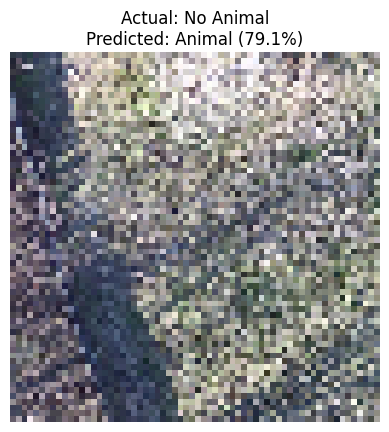

In [5]:
# Cell 5: Visualization
def predict_image(index):
    # Get image from dataset
    img = X[index]
    actual_label = "Animal" if y[index] == 1 else "No Animal"
    
    # Reshape for model prediction
    img_for_model = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)
    
    # Predict
    prediction = model.predict(img_for_model)
    predicted_label = "Animal" if prediction[0][0] > 0.5 else "No Animal"
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

    # Plot
    plt.imshow(cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB))
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label} ({confidence*100:.1f}%)")
    plt.axis('off')
    plt.show()

# Test on a random image from the dataset
import random
random_idx = random.randint(0, len(X)-1)
predict_image(random_idx)